In [86]:
import pandas as pd
import pyspark.ml as M
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession \
    .builder \
    .appName("yelp-reccomender") \
    .getOrCreate()

In [3]:
schema = T.StructType([
    T.StructField("_c01", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True),
    T.StructField("business_id", T.StringType(), True),   
    T.StructField("city", T.StringType(), True),   
    T.StructField("categories", T.StringType(), True),
    T.StructField("review_id", T.StringType(), True),   
    T.StructField("text", T.StringType(), True),      
    T.StructField("stars", T.FloatType(), True)                    
])

In [6]:
lv = spark.read.csv("../data/raw/Las_Vegas_reviews.csv", header=True, multiLine=True, schema=schema, quote="\"", escape="\"")
# lv = spark.read.csv("../../../yelp_dataset/Phoenix_reviews_Cath.csv", header=True, multiLine=True, schema=schema, quote="\"", escape="\"")

In [7]:
# df = lv.filter(
#     (F.col('categories').contains('Restaurants')) |
#     (F.col('categories').contains('Food'))
# )
df = lv.withColumn('list_cat', F.split(lv.categories, ', ')) # string to list
df = df.withColumn('list_cat', F.explode_outer('list_cat')) # list to rows
indexer = M.feature.StringIndexer(inputCol="list_cat", outputCol="cat_num") # convert category to numerical indices
indexed = indexer.fit(df).transform(df)
encoder = M.feature.OneHotEncoder(inputCol="cat_num", outputCol="cat_onehot")
# params = {encoder.dropLast: False}
# encoded_df = encoder.transform(indexed, params)

In [8]:
params = {encoder.dropLast: False}
ohe = encoder.fit(indexed)
encoded_df = ohe.transform(indexed, params)

In [9]:
cat_group = indexed[['cat_num']].groupby("cat_num").count()

In [10]:
reverse_index = M.feature.IndexToString(inputCol='cat_num', outputCol='cat_names')

In [11]:
names_df = reverse_index.transform(cat_group)

In [48]:
a = names_df.orderBy(F.desc("count")).take(12)

In [49]:
df = pd.DataFrame(a[2:])[[2,1]]
df = df.rename(columns={2:'Category', 1:'Count'})

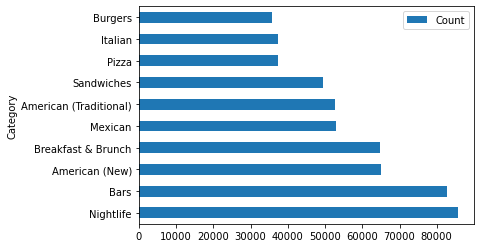

In [50]:
df.plot.barh(x="Category", y="Count")

In [4]:
# lv = pd.read_csv("../../../yelp_dataset/Las_Vegas_reviews.csv")
lv = pd.read_csv("../data/raw/Las_Vegas_reviews.csv")

In [5]:
lv.head()

,Unnamed: 0,name,business_id,city,categories,review_id,text,stars
0,0,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",WUAt5-krh075Ie44np8Hew,So why would I be giving a Fast Food chain loc...,5.0
1,1,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",S9vIs-je49jqbhpWSQ8yHg,I come here bout 3x's a mo. & I just can't do ...,2.0
2,2,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",i2Soid_X8XsSTyIrPOst6g,WORST experience EVER!!!!! never have i ate an...,1.0
3,3,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",uDYGaAOUgo7SLuH5nUZs3w,Hot fresh food usually. Staff seems to turn o...,4.0
4,4,Carl's Jr,fnZrZlqW1Z8iWgTVDfv_MA,Las Vegas,"Mexican, Restaurants, Fast Food",Xg7HuBvuZHTBog1G_2Wk0w,Beer battered cod fish seems really rubbery. I...,3.0


In [42]:
a = lv['text'].to_dict()

In [45]:
a[0]

"So why would I be giving a Fast Food chain location a 5 star rating? For some reason, THIS Carl's Jr. is one in a million. Yes, there is an In-and-Out across the street but this Carl's Jr is everything In-and-Out can't be. \n\nFirst of all, THEIR SHAKES!!! Carl's Jr. shakes are hand scooped, and mixed upon order unlike they're competitors across the street. The chocolate shake IS the best I've EVER had from a drive thru. Point for Carl's Jr.\n\nSecond, the hand battered chicken strips were literally hand battered, i watch the guy through the service window dip and fry. The single best chicken strips i've ever had (but they may need new sauces, tired of BBQ...but still outstanding nonetheless). Point 2 for Carl's Jr\n\nLastly, Hours. 24/7 on the weekends and midnight on the weekdays. Brilliant for my late night guru-ness.\n\nWorth the drive!"

In [60]:
import json
with open('../data/autophrase_in/reviews.txt', 'w') as f:
    i = 0
    for i, review in enumerate(lv.text):
        if i < 10:
            f.write(json.dumps({i:review}))
            f.write(",")
        else:
            break

In [174]:
import json
# with open('../data/autophrase_in/reviews.txt', 'w') as f:
with open('../../DSC180A-Project/data/in/yelp_reviews1.txt', 'w') as f:
    i = 0
    for review in lv.text:
#         i+=1
#         if i < 10:
        f.write(review)
        f.write("\n.\n")
#         else:
#             break
#     f.write(json.dumps(lv.text.to_dict()))

In [1]:
# with open('../data/autophrase_in/reviews.txt', 'w') as f:
#     f.write('test')
# with open('../data/autophrase_out/segmentation.txt', 'r') as f:
with open('../../DSC180A-Project/data/out/segmentation.txt', 'r') as f:
# with open('../../DSC180A-Project/data/in/yelp_reviews.txt', 'r') as f:
# with open('../../DSC180A-Project/data/in/yelp_reviews1.txt', 'r') as f:
    a = f.read()
    b = a.split("\n.\n")

In [7]:
b[1]

"I come here bout 3x's a mo. & I just can't do it anymore. The cook that works on <phrase>late shift</phrase> SUCKS. The <phrase>manager</phrase> is sweet. I always get <phrase>chicken</phrase> <phrase>Santa Fe</phrase> & I have to request <phrase>fresh lettuce</phrase>. The <phrase>chicken</phrase> is <phrase>rubber</phrase>, the <phrase>bread</phrase> hard on the outside. Tonight I received it the same way however my <phrase>cheese</phrase> wasn't even melted. \nIM DONE!  I go after work arrive always bout 1130pm. I'm sooooo DONE!!! Let me know when u get a new night cook! \nYes I do know <phrase>food</phrase> I've been in the <phrase>industry</phrase> 15 yrs."

In [3]:
a[:1205]

"So why would I be giving a <phrase>Fast Food chain</phrase> location a 5 <phrase>star</phrase> rating? For some reason, THIS <phrase>Carl's Jr</phrase>. is one in a million. Yes, there is an In-and-Out across the street but this <phrase>Carl's Jr</phrase> is everything In-and-Out can't be. \n\nFirst of all, THEIR SHAKES!!! <phrase>Carl's Jr</phrase>. shakes are <phrase>hand scooped</phrase>, and mixed upon <phrase>order</phrase> unlike they're competitors across the street. The <phrase>chocolate</phrase> shake IS the best I've EVER had from a <phrase>drive thru</phrase>. Point for <phrase>Carl's Jr</phrase>.\n\nSecond, the <phrase>hand battered</phrase> <phrase>chicken</phrase> <phrase>strips</phrase> were literally <phrase>hand battered</phrase>, i <phrase>watch</phrase> the guy through the service window dip and fry. The <phrase>single</phrase> best <phrase>chicken</phrase> <phrase>strips</phrase> i've ever had (but they may need new <phrase>sauces</phrase>, tired of BBQ...but still

In [63]:
with open('../data/autophrase_in/reviews.txt') as f:
    data = json.load(f)

In [12]:
a = lv.groupby('review_id')['stars'].count()

TypeError: 'GroupedData' object is not subscriptable

In [32]:
indexed

DataFrame[_c01: int, name: string, business_id: string, city: string, categories: string, review_id: string, text: string, stars: float, list_cat: string, cat_num: double]

In [37]:
indexed.select("name", "list_cat").filter(F.col("list_cat")=="Arts & Entertainment").take(1)

[Row(name='Chinese New Year Celebration', list_cat='Arts & Entertainment')]